# TASK 2 - by Ayomiposi Adebayo

In [ ]:
# Importing the all necessary libraries for the training  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Conv2D, MaxPooling2D, Flatten, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [10]:
# This is the cleaned data set we are working with
df = pd.read_csv("apod_cleaned.csv", sep=';')
df[['date', 'title', 'media_url', 'explanation','keywords', 'clean_explanation', 'image_data', 'label']].reset_index(drop=True)

,date,title,media_url,explanation,keywords,clean_explanation,image_data,label
0,1995-06-16,Neutron Star Earth,https://apod.nasa.gov/apod/image/e_lens.gif,Today's Picture : Explanation : If the Earth c...,"today, picture, explanation, transform, ultra,...",today pictur explan earth could somehow transf...,[[[0. 0. 0.]\n [0. 0. 0.]\n [0. 0. 0.]\n .....,star
1,1995-06-20,Pleiades Star Cluster,https://apod.nasa.gov/apod/image/pleiades2.gif,"Today's Picture : June 20, 1995 The Pleiades S...","today, picture, June, Pleiades, Star, Cluster,...",today pictur june pleiad star cluster pictur m...,[[[0.06666667 0.04313725 0.0627451 ]\n [0.058...,star
2,1995-06-21,Supernova 1987a Aftermath,https://apod.nasa.gov/apod/image/sn1987a_hst.gif,"Today's Picture : June 21, 1995 The Aftermath ...","today, picture, June, Aftermath, Great, Supern...",today pictur june aftermath great supernova pi...,[[[0.89019608 0.89019608 0.89019608]\n [0.670...,star
3,1995-06-22,Earth from Apollo 17,https://apod.nasa.gov/apod/image/earth_a17.gif,In 1972 Astronauts on the United States's last...,"Astronauts, lunar, mission, Apollo, take, pict...",astronaut unit statess last lunar mission apol...,[[[0.03529412 0. 0. ]\n [0.050...,other
4,1995-06-23,Gamma Ray Sky Map,https://apod.nasa.gov/apod/image/egret_gro.gif,"What if you could ""see"" gamma rays ? This comp...","gamma, ray, computer, process, image, represen...",could see gamma ray comput process imag repres...,[[[0. 0. 0.]\n [0. 0. 0.]\n [0. 0. 0.]\n .....,other
...,...,...,...,...,...,...,...,...
9936,2023-12-26,IC 443 : The Jellyfish Nebula,https://apod.nasa.gov/apod/image/2312/Jellyfis...,Why is this jellyfish swimming in a sea of sta...,"jellyfish, swimming, sea, star, drift, near, b...",jellyfish swim sea star drift near bright star...,[[[0.22745098 0.28235294 0.31372549]\n [0.196...,nebula
9937,2023-12-27,Rainbow Aurora over Icelandic Waterfall,https://apod.nasa.gov/apod/image/2312/ArchFall...,"Yes, but can your aurora do this ? First, yes,...","yes, aurora, look, like, rainbow, different, p...",ye aurora first ye aurora look like rainbow ev...,[[[0.08235294 0.08627451 0.10588235]\n [0.086...,star
9938,2023-12-28,Jupiter and the Geminid,https://apod.nasa.gov/apod/image/2312/G0030446...,"For a brief moment, this brilliant fireball me...","brief, moment, brilliant, fireball, meteor, ou...",brief moment brilliant firebal meteor outshon ...,[[[0.06666667 0.09019608 0.08235294]\n [0.066...,star
9939,2023-12-29,Shakespeare in Space,https://apod.nasa.gov/apod/image/2312/STScI-Ur...,"In 1986, Voyager 2 became the only spacecraft ...","Voyager, spacecraft, explore, ice, giant, plan...",voyag becam spacecraft explor ice giant planet...,[[[0. 0. 0.]\n [0. 0. 0.]\n [0. 0. 0.]\n .....,other


In [11]:
# Loading the data set
# Image normalization has already been included in Task 1

X_image_train = np.load( "X_image_train.npy")
X_image_val = np.load("X_image_val.npy")
X_image_test = np.load("X_image_test.npy")

# Text input
X_text_train = np.load("X_text_train.npy")
X_text_val = np.load("X_text_val.npy")
X_text_test = np.load("X_text_test.npy")

# Labels (already one-hot encoded)
y_train = np.load("y_train.npy")
y_val = np.load("y_val.npy")
y_test = np.load("y_test.npy")

In [ ]:
# Preparing class weights
y_train_labels = np.argmax(y_train, axis=1)
class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights = dict(enumerate(class_weights_array))

In [ ]:
# CNN branch
# This part of the code trains the image
image_input = Input(shape=(224, 224, 3))
x = Conv2D(32, (3,3), activation='relu', padding='same')(image_input)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x) # I added extra convolution layers to improve the accuracy
x = MaxPooling2D((2,2))(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)

In [14]:
# LSTM branch

text_input = Input(shape=(X_text_train.shape[1],))  # Use pre-tokenized input shape
embedding = Embedding(input_dim=10000, output_dim=64)(text_input)
lstm = LSTM(64)(embedding)


In [ ]:
# Combining branches
# combining both CNN branch and the LSTM branch 
combined = Concatenate()([x, lstm])
output = Dense(y_train.shape[1], activation='softmax')(combined)

model = Model(inputs=[image_input, text_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

#model.summary()


In [ ]:
# This part of the code initiated the training process
history = model.fit(
    [X_image_train, X_text_train], y_train,
    validation_data=([X_image_val, X_text_val], y_val),
    epochs=20,
    batch_size=32,
    class_weight=class_weights 
)
test_loss, test_acc = model.evaluate([X_image_test, X_text_test], y_test) # evaluates you test data to see the accuracy
print(f"\n✅ Test Accuracy: {test_acc:.4f} | Loss: {test_loss:.4f}") # prints the final test accuracy

Epoch 1/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 121s 550ms/step - accuracy: 0.4041 - loss: 1.3805 - val_accuracy: 0.5453 - val_loss: 1.0734
Epoch 2/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 107s 492ms/step - accuracy: 0.4931 - loss: 1.1440 - val_accuracy: 0.6378 - val_loss: 0.9004
Epoch 3/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 107s 492ms/step - accuracy: 0.6600 - loss: 0.8082 - val_accuracy: 0.5825 - val_loss: 0.9250
Epoch 4/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 107s 491ms/step - accuracy: 0.6652 - loss: 0.6923 - val_accuracy: 0.6831 - val_loss: 0.7407
Epoch 5/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 107s 490ms/step - accuracy: 0.7009 - loss: 0.6447 - val_accuracy: 0.7123 - val_loss: 0.6559
Epoch 6/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 107s 491ms/step - accuracy: 0.7246 - loss: 0.5832 - val_accuracy: 0.6197 - val_loss: 0.8324
Epoch 7/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 107s 491ms/step - accuracy: 0.7311 - loss: 0.5446 - val_accuracy: 0.7163 - val_loss: 0.6523
Epoch 8/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 107s 490ms/step - accuracy: 0.7790 -

In [67]:
# Saving the entire model to a file
model.save('apod-hybrid-model.h5')  # HDF5 format
# Or
#model.save('apod-hybrid-model.keras')  # Keras format (recommended for newer versions)


In [ ]:
from tensorflow.keras.models import load_model

# Loading the saved model from the .h5 file
model = load_model('apod-hybrid-model.h5')

# Printing the model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 224, 224,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 112, 112,  │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 56, 56,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 56, 56,    │     36,928 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 28, 28,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 14, 14,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 200, 64)   │    640,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 25088)     │          0 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     33,024 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 25152)     │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │    100,612 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 903,814 (3.45 MB)

 Trainable params: 903,812 (3.45 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


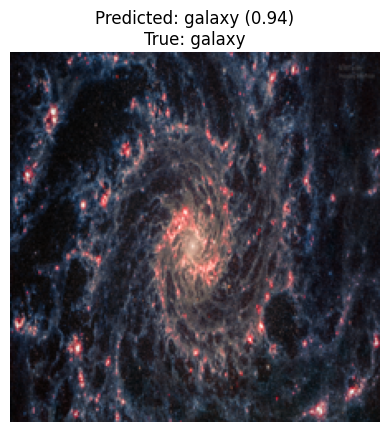

In [ ]:
# Picking a random index from your test set
idx = np.random.randint(0, len(X_image_test))

# Getting the image and text input
img = X_image_test[idx]
txt = X_text_test[idx]

# Model expecting batch dimension
img_input = np.expand_dims(img, axis=0)
txt_input = np.expand_dims(txt, axis=0)

# Predicting
pred_probs = model.predict([img_input, txt_input])
pred_class = np.argmax(pred_probs)
confidence = np.max(pred_probs)

# Mapping class index to label name
label_names = list(df['label'].unique())
pred_label = label_names[pred_class]
true_label = label_names[np.argmax(y_test[idx])]

# Showing the image and prediction
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {pred_label} ({confidence:.2f})\nTrue: {true_label}")
plt.show()


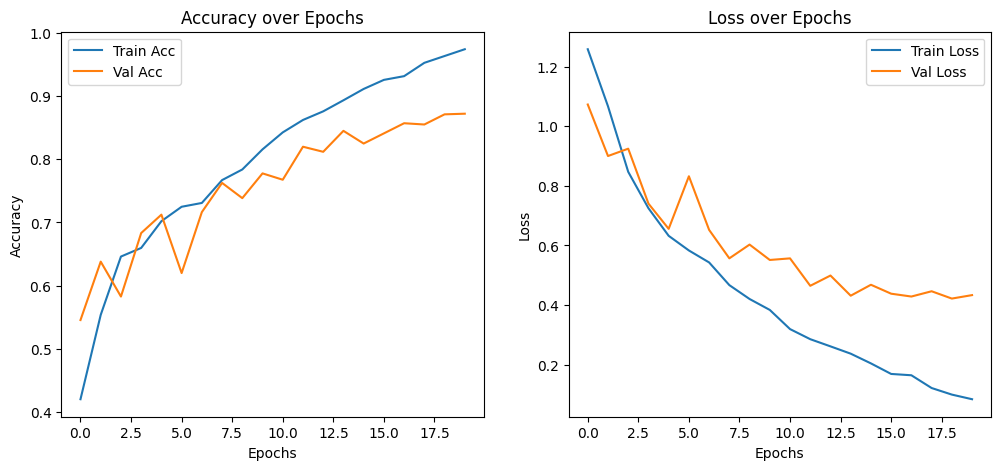

In [ ]:
# Plotting 
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()